 ## Goal
1. Predict Pricing of a pre-owned car?
2. Why should the customer pay the predicted amount? Which car features or the contextual data are the primary reason for pricing the cars? Basically, the points a seller should convey while selling any particular car for the quoted price.
3. Any insights which can help the pre-owned car selling market?

#### Importing libraries which we are going to use in this notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp
from scipy import stats

# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgbm

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

#### Importing dataset and declaration of maximum columns which is to be imported.

In [2]:
valid_part = 0.3
pd.set_option('max_columns',100)
df=pd.read_csv("C:\\Users\\n1a9m\\OneDrive\\Desktop\\JOB\\Glow Road\\vehicles.csv")
df.head()

Unnamed: 0          id                                                url  \
0           0  7240372487  https://auburn.craigslist.org/ctd/d/auburn-uni...   
1           1  7240309422  https://auburn.craigslist.org/cto/d/auburn-201...   
2           2  7240224296  https://auburn.craigslist.org/cto/d/auburn-200...   
3           3  7240103965  https://auburn.craigslist.org/cto/d/lanett-tru...   
4           4  7239983776  https://auburn.craigslist.org/cto/d/auburn-200...   

   region                     region_url  price    year manufacturer  \
0  auburn  https://auburn.craigslist.org  35990  2010.0    chevrolet   
1  auburn  https://auburn.craigslist.org   7500  2014.0      hyundai   
2  auburn  https://auburn.craigslist.org   4900  2006.0          bmw   
3  auburn  https://auburn.craigslist.org   2000  1974.0    chevrolet   
4  auburn  https://auburn.craigslist.org  19500  2005.0         ford   

                  model  condition    cylinders    fuel  odometer  \
0  corvette grand sport       good  8 cylinders     gas   32742.0   
1                sonata  excellent  4 cylinders     gas   93600.0   
2               x3 3.0i       good  6 cylinders     gas   87046.0   
3                  c-10       good  4 cylinders     gas  190000.0   
4           f350 lariat  excellent  8 cylinders  diesel  116000.0   

  title_status transmission                VIN drive       size    type  \
0        clean        other  1G1YU3DW1A5106980   rwd        NaN   other   
1        clean    automatic  5NPEC4AB0EH813529   fwd        NaN   sedan   
2        clean    automatic                NaN   NaN        NaN     SUV   
3        clean    automatic                NaN   rwd  full-size  pickup   
4         lien    automatic                NaN   4wd  full-size  pickup   

  paint_color                                          image_url  \
0         NaN  https://images.craigslist.org/00N0N_ipkbHVZYf4...   
1         NaN  https://images.craigslist.org/00s0s_gBHYmJ5o7y...   
2        blue  https://images.craigslist.org/00B0B_5zgEGWPOrt...   
3        blue  https://images.craigslist.org/00M0M_6o7KcDpArw...   
4        blue  https://images.craigslist.org/00p0p_b95l1EgUfl...   

                                         description state        lat  \
0  Carvana is the safer way to buy a car During t...    al  32.590000   
1  I'll move to another city and try to sell my c...    al  32.547500   
2  Clean 2006 BMW X3 3.0I.  Beautiful and rare Bl...    al  32.616807   
3  1974 chev. truck (LONG BED) NEW starter front ...    al  32.861600   
4  2005 Ford F350 Lariat (Bullet Proofed). This t...    al  32.547500   

        long              posting_date  
0 -85.480000  2020-12-02T08:11:30-0600  
1 -85.468200  2020-12-02T02:11:50-0600  
2 -85.464149  2020-12-01T19:50:41-0600  
3 -85.216100  2020-12-01T15:54:45-0600  
4 -85.468200  2020-12-01T12:53:56-0600

#### Now, let's drop the columuns which we don't need after the comprehensive study of our dataset. As we can see we dont have any specific use of urls, description, state, latitude, longitude etc. in our data analysis. These will create unnecessary clutter and will forestall our work.

In [3]:
drop_columns = ['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'model', 'title_status', 'VIN', 
                'size', 'image_url', 'description', 'state', 'lat','long', 'posting_date']
train0 = df.drop(columns = drop_columns)
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         458213 non-null  int64  
 1   year          457163 non-null  float64
 2   manufacturer  439993 non-null  object 
 3   condition     265273 non-null  object 
 4   cylinders     287073 non-null  object 
 5   fuel          454976 non-null  object 
 6   odometer      402910 non-null  float64
 7   transmission  455771 non-null  object 
 8   drive         324025 non-null  object 
 9   type          345475 non-null  object 
 10  paint_color   317370 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 38.5+ MB


#### Preparation of data by dropping fields with null values. We prepare the data by determining the categorical features with label encoder function. In addendum let's map those numerical values with their corresponding variable name for our future reference. Let's us also remove those fields where price is equal to zero.

In [4]:
train0 = train0.dropna()
# Determining the categorical features 
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train0.columns.values.tolist()
for col in features:
    if train0[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
mapping = []
for col in categorical_columns:
    if col in train0.columns:
        le = LabelEncoder()
        le.fit(list(train0[col].astype(str).values))
        train0[col] = le.transform(list(train0[col].astype(str).values))
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)
        mapping.append(le_name_mapping)

#Dropping 0 values in price
train0 = train0[train0['price']!=0]

train0.info()

{'acura': 0, 'alfa-romeo': 1, 'aston-martin': 2, 'audi': 3, 'bmw': 4, 'buick': 5, 'cadillac': 6, 'chevrolet': 7, 'chrysler': 8, 'datsun': 9, 'dodge': 10, 'ferrari': 11, 'fiat': 12, 'ford': 13, 'gmc': 14, 'harley-davidson': 15, 'honda': 16, 'hyundai': 17, 'infiniti': 18, 'jaguar': 19, 'jeep': 20, 'kia': 21, 'land rover': 22, 'lexus': 23, 'lincoln': 24, 'mazda': 25, 'mercedes-benz': 26, 'mercury': 27, 'mini': 28, 'mitsubishi': 29, 'nissan': 30, 'pontiac': 31, 'porsche': 32, 'ram': 33, 'rover': 34, 'saturn': 35, 'subaru': 36, 'tesla': 37, 'toyota': 38, 'volkswagen': 39, 'volvo': 40}
{'excellent': 0, 'fair': 1, 'good': 2, 'like new': 3, 'new': 4, 'salvage': 5}
{'10 cylinders': 0, '12 cylinders': 1, '3 cylinders': 2, '4 cylinders': 3, '5 cylinders': 4, '6 cylinders': 5, '8 cylinders': 6, 'other': 7}
{'diesel': 0, 'electric': 1, 'gas': 2, 'hybrid': 3, 'other': 4}
{'automatic': 0, 'manual': 1, 'other': 2}
{'4wd': 0, 'fwd': 1, 'rwd': 2}
{'SUV': 0, 'bus': 1, 'convertible': 2, 'coupe': 3, 'hatch

#### Bar plot between price and odometer. 

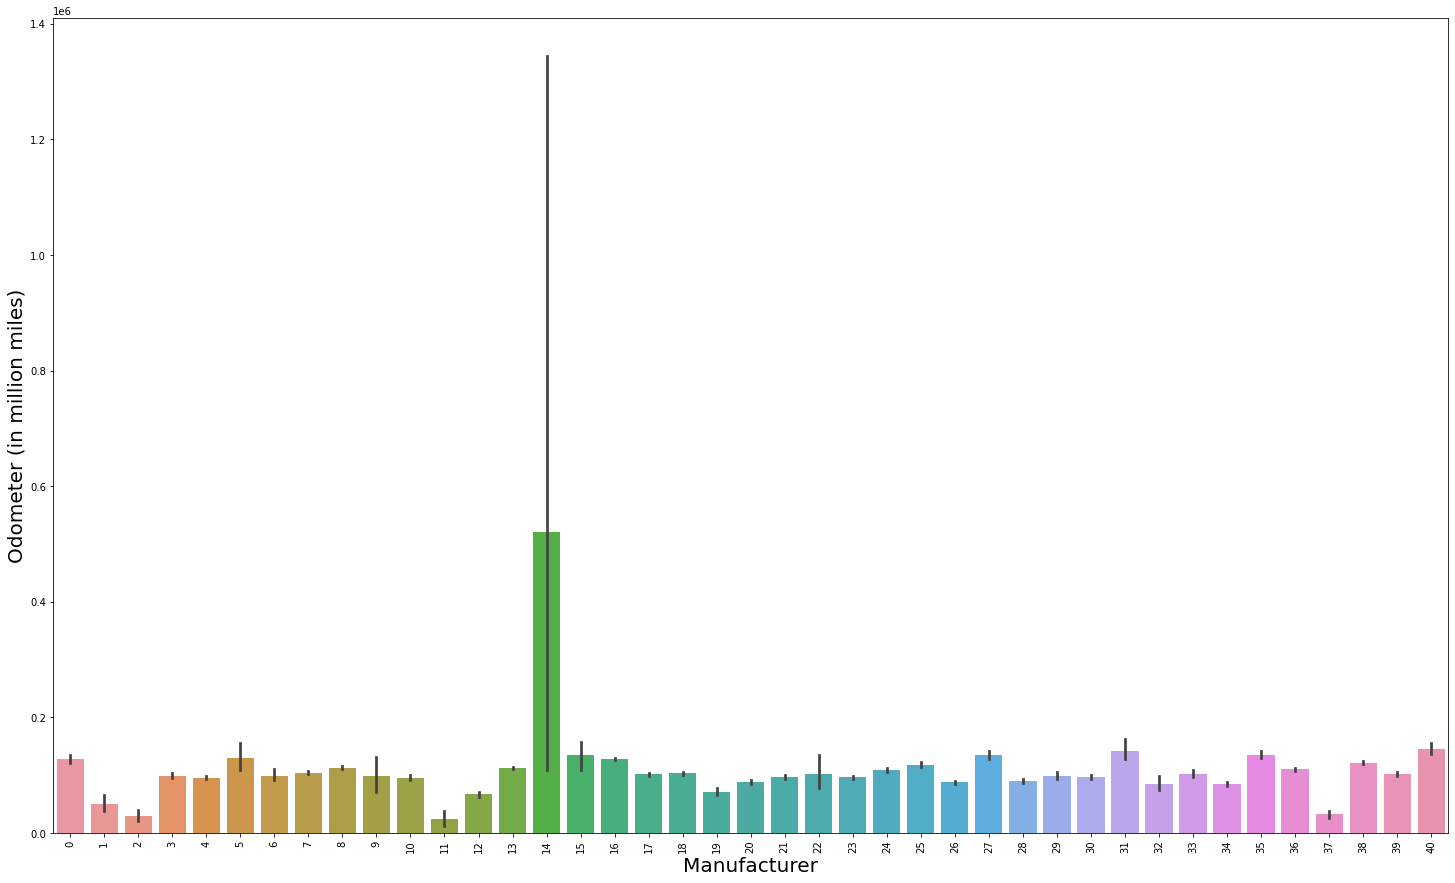

In [5]:
train0=train0.sort_values(by=['odometer'],ascending=False)
plt.figure(figsize=(25,15))
sns.barplot(x=train0.manufacturer, y=train0.odometer)
plt.xticks(rotation= 90)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Odometer (in million miles)', fontsize=20)
plt.show()

#### Bar Plot between price and manufacturer

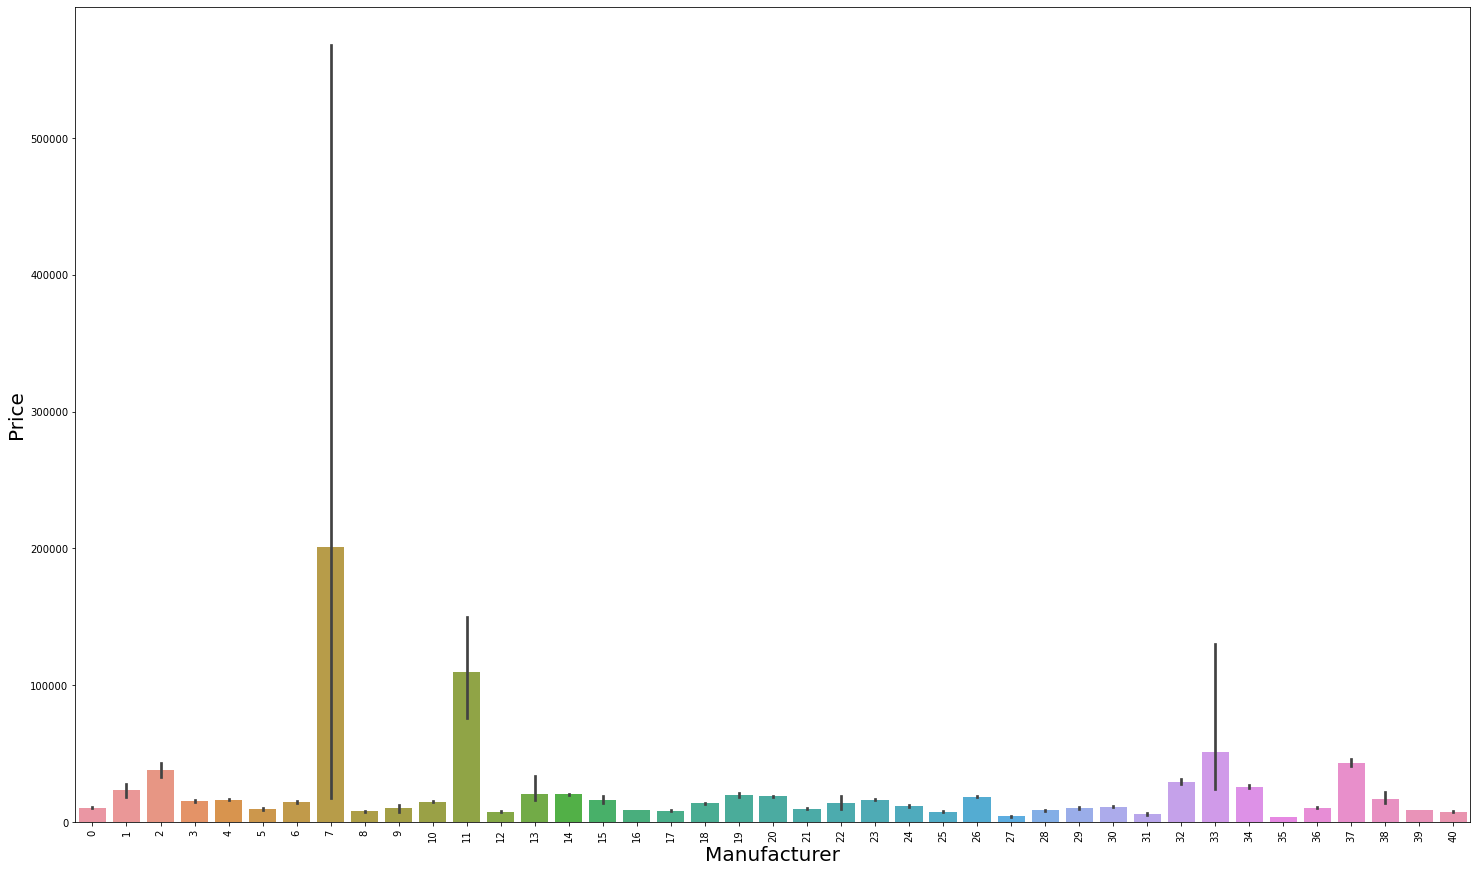

In [6]:
train0=train0.sort_values(by=['price'],ascending=False)
plt.figure(figsize=(25,15))
sns.barplot(x=train0.manufacturer, y=train0.price)
plt.xticks(rotation= 90)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.show()

##### The number 7 and 11 manufacture viz., Chevrolet and Ferrari have highest average prices among all manufacturers. As we can see the sheer length of black lines which corresponds to the outliers in the given data. We need to remove the outliers by placing some constraints.

#### Interactive donut chart for describing relation between paint color and fuel type of a car.

In [7]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

dieselLabels = train0[train0["fuel"]=="0"].paint_color.value_counts().head(10).index
dieselValues = train0[train0["fuel"]=="0"].paint_color.value_counts().head(10).values
electricLabels = train0[train0["fuel"]=="1"].paint_color.value_counts().head(10).index
electricValues = train0[train0["fuel"]=="1"].paint_color.value_counts().head(10).values
gasLabels = train0[train0["fuel"]=="2"].paint_color.value_counts().head(10).index
gasValues = train0[train0["fuel"]=="2"].paint_color.value_counts().head(10).values
hybridLabels = train0[train0["fuel"]=="3"].paint_color.value_counts().head(10).index
hybridValues = train0[train0["fuel"]=="3"].paint_color.value_counts().head(10).values

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=4, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=gasLabels, values=gasValues, name="Gas Car"),
              1, 1)
fig.add_trace(go.Pie(labels=dieselLabels, values=dieselValues, name="Diesel Car"),
              1, 2)
fig.add_trace(go.Pie(labels=electricLabels, values=electricValues, name="Electric Car"),
              1, 3)
fig.add_trace(go.Pie(labels=hybridLabels, values=hybridValues, name="Hybrid Car"),
              1, 4)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.show()


#### Changing the datatype of year and odometer to facilitate future analysis

In [8]:
train0['year'] = (train0['year']).astype(np.int64)
train0['odometer'] = train0['odometer'].astype(np.int64)

train_stat = train0.describe(percentiles = [.025, .05, .1, .9, .95, .975])
train_stat

price           year   manufacturer      condition  \
count  1.280630e+05  128063.000000  128063.000000  128063.000000   
mean   4.501824e+04    2009.942763      18.713454       1.234143   
std    1.011219e+07       8.017627      11.186145       1.139893   
min    1.000000e+00    1923.000000       0.000000       0.000000   
2.5%   1.400000e+03    1992.000000       4.000000       0.000000   
5%     2.150000e+03    1998.000000       5.000000       0.000000   
10%    3.100000e+03    2002.000000       7.000000       0.000000   
50%    1.067500e+04    2012.000000      16.000000       2.000000   
90%    3.299000e+04    2017.000000      38.000000       3.000000   
95%    3.899000e+04    2019.000000      38.000000       3.000000   
97.5%  4.299000e+04    2019.000000      39.000000       3.000000   
max    3.615215e+09    2021.000000      40.000000       5.000000   

           cylinders           fuel      odometer   transmission  \
count  128063.000000  128063.000000  1.280630e+05  128063.000000   
mean        4.605757       1.942731  1.232780e+05       0.229129   
std         1.277498       0.520451  5.712801e+06       0.584570   
min         0.000000       0.000000  0.000000e+00       0.000000   
2.5%        3.000000       0.000000  3.318150e+03       0.000000   
5%          3.000000       1.000000  1.036420e+04       0.000000   
10%         3.000000       2.000000  2.086000e+04       0.000000   
50%         5.000000       2.000000  1.000000e+05       0.000000   
90%         6.000000       2.000000  1.870000e+05       1.000000   
95%         6.000000       2.000000  2.132099e+05       2.000000   
97.5%       6.000000       3.000000  2.410000e+05       2.000000   
max         7.000000       4.000000  2.043756e+09       2.000000   

               drive           type    paint_color  
count  128063.000000  128063.000000  128063.000000  
mean        0.810156       6.089948       5.581526  
std         0.772726       4.022163       3.999686  
min         0.000000       0.000000       0.000000  
2.5%        0.000000       0.000000       0.000000  
5%          0.000000       0.000000       0.000000  
10%         0.000000       0.000000       0.000000  
50%         1.000000       8.000000       7.000000  
90%         2.000000      10.000000      10.000000  
95%         2.000000      11.000000      10.000000  
97.5%       2.000000      12.000000      10.000000  
max         2.000000      12.000000      11.000000

I suggest to make filters only for features that were numeric in the basic dateset: price, year, odometer

There are problems:

- smallest values: year

- largest values: price, odometer

I suggest adding a filter by low values of price because free cars and cars which cost as scrap require other models. Setting prices in between 5 to 95 percentile to remove outliers.

#### Now, we will write a function for us in order to remove abnormal values or outliers.

In [9]:
def abnormal_filter(df, threshold_first, threshold_second):
    # Abnormal values filter for DataFrame df:
    # threshold_first (2.5%-min or max-97.5%)
    # threshold_second (second diff., times)
    df_describe = df.describe([.05, .1, .9, .95])
    cols = df_describe.columns.tolist()
    i = 0
    abnorm = 0
    for col in cols:
        i += 1
        # abnormal smallest
        P10_5 = df_describe.loc['10%',col]-df_describe.loc['5%',col]
        P_max_min = df_describe.loc['max',col]-df_describe.loc['min',col]
        if P10_5 != 0:
            if (df_describe.loc['5%',col]-df_describe.loc['min',col])/P10_5 > threshold_second:
                #abnormal smallest filter
                df = df[(df[col] >= df_describe.loc['5%',col])]
                print('1: ', i, col, df_describe.loc['min',col],df_describe.loc['5%',col],df_describe.loc['10%',col])
                abnorm += 1
        else:
            if P_max_min > 0:
                if (df_describe.loc['5%',col]-df_describe.loc['min',col])/P_max_min > threshold_first:
                    # abnormal smallest filter
                    df = df[(df[col] >= df_describe.loc['5%',col])]
                    print('2: ', i, col, df_describe.loc['min',col],df_describe.loc['5%',col],df_describe.loc['max',col])
                    abnorm += 1

        
        # abnormal biggest
        P95_90 = df_describe.loc['95%',col]-df_describe.loc['90%',col]
        if P95_90 != 0:
            if (df_describe.loc['max',col]-df_describe.loc['95%',col])/P95_90 > threshold_second:
                #abnormal biggest filter
                df = df[(df[col] <= df_describe.loc['95%',col])]
                print('3: ', i, col, df_describe.loc['90%',col],df_describe.loc['95%',col],df_describe.loc['max',col])
                abnorm += 1
        else:
            if P_max_min > 0:
                if ((df_describe.loc['max',col]-df_describe.loc['95%',col])/P_max_min > threshold_first) & (df_describe.loc['95%',col] > 0):
                    # abnormal biggest filter
                    df = df[(df[col] <= df_describe.loc['95%',col])]
                    print('4: ', i, col, df_describe.loc['min',col],df_describe.loc['95%',col],df_describe.loc['max',col])
                    abnorm += 1
    print('Number of abnormal values =', abnorm)
    return df

In [10]:
train0 = abnormal_filter(train0, 0.5, 3)
train0.info()

3:  1 price 32990.0 38990.0 3615215112.0
1:  2 year 1923.0 1998.0 2002.0
3:  7 odometer 187000.0 213209.89999999994 2043755555.0
Number of abnormal values = 3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 110568 entries, 185870 to 376449
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   price         110568 non-null  int64
 1   year          110568 non-null  int64
 2   manufacturer  110568 non-null  int32
 3   condition     110568 non-null  int32
 4   cylinders     110568 non-null  int32
 5   fuel          110568 non-null  int32
 6   odometer      110568 non-null  int64
 7   transmission  110568 non-null  int32
 8   drive         110568 non-null  int32
 9   type          110568 non-null  int32
 10  paint_color   110568 non-null  int32
dtypes: int32(8), int64(3)
memory usage: 6.7 MB


#### Placing Manual filter: price (upper (95%) and lower (5%)), year (lower - 5%), odometer (upper -95%)


In [11]:
train0 = train0[((train0['price'] >= 1400) & (train0['price'] < 40000) & (train0['year'] >= 1998) & (train0['odometer'] < 217000))]
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108304 entries, 185870 to 291495
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   price         108304 non-null  int64
 1   year          108304 non-null  int64
 2   manufacturer  108304 non-null  int32
 3   condition     108304 non-null  int32
 4   cylinders     108304 non-null  int32
 5   fuel          108304 non-null  int32
 6   odometer      108304 non-null  int64
 7   transmission  108304 non-null  int32
 8   drive         108304 non-null  int32
 9   type          108304 non-null  int32
 10  paint_color   108304 non-null  int32
dtypes: int32(8), int64(3)
memory usage: 6.6 MB


#### Plotting a box plot, probability plot and histogram for price.

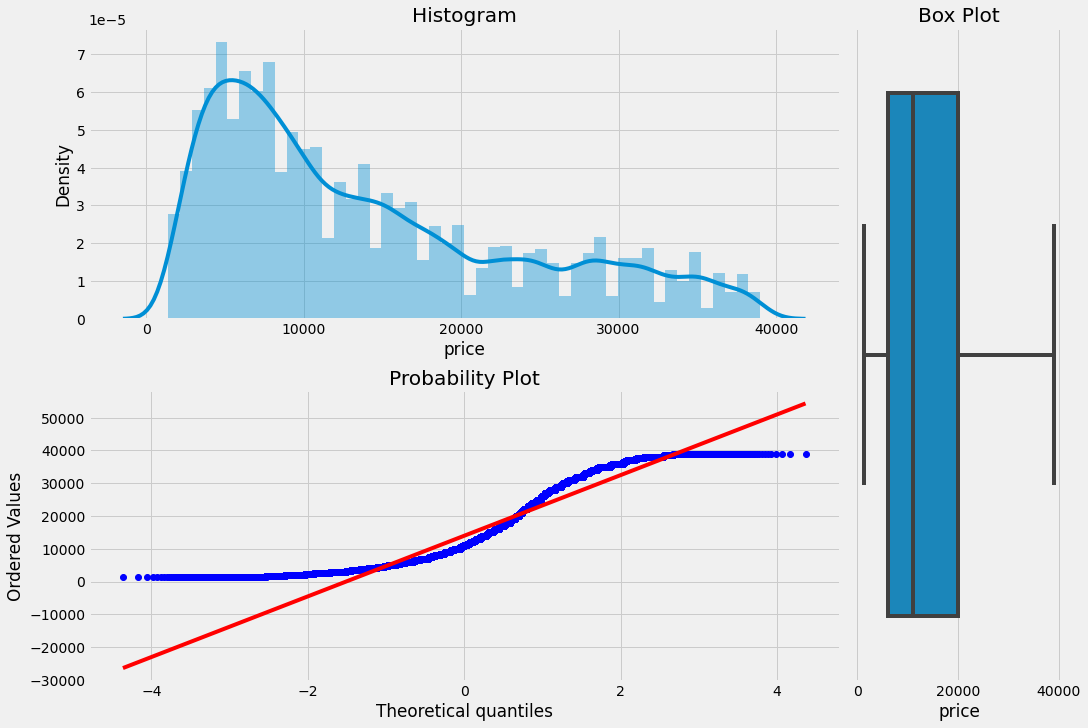

In [12]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    plt.style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    
    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(train0, 'price')

#### Generating a 3d plot for to show relation between price, odometer and years.

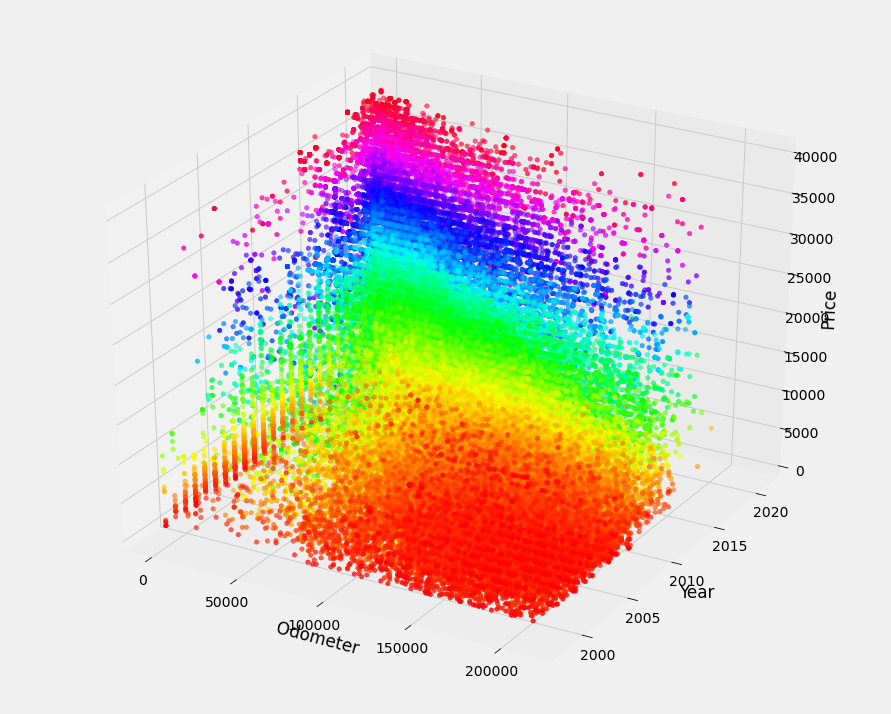

In [13]:

fig = plt.figure(figsize=(14,12))
ax = plt.axes(projection="3d")

z_points = train0['price']
x_points = train0['odometer']
y_points = train0['year']
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

ax.set_xlabel('Odometer')
ax.set_ylabel('Year')
ax.set_zlabel('Price')

plt.show()

##### We can see cars with odometer reading less than 50000 and years more than 2015 are having comparitively higher prices than other cars, vice versa.

In [14]:
target = train0['price']
del train0['price']

#### FE: tuning models and building the feature importance diagrams

##### LGBM

In [15]:
X = train0
z = target

#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)
train_set = lgbm.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgbm.Dataset(Xval, Zval, silent=False)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgbm.train(params, train_set = train_set, num_boost_round=2000,
                   early_stopping_rounds=50,verbose_eval=10, valid_sets=valid_set)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5113
[LightGBM] [Info] Number of data points in the train set: 86643, number of used features: 10
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 13962.941184
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 7258.03
[20]	valid_0's rmse: 5803.26
[30]	valid_0's rmse: 4930.44
[40]	valid_0's rmse: 4395.08
[50]	valid_0's rmse: 4055.13
[60]	valid_0's rmse: 3874.88
[70]	valid_0'

In [16]:
r2_score(Zval, modelL.predict(Xval))

0.9206368414079759

#### That's an accuracy of 92% with Light Gradient Boosting.

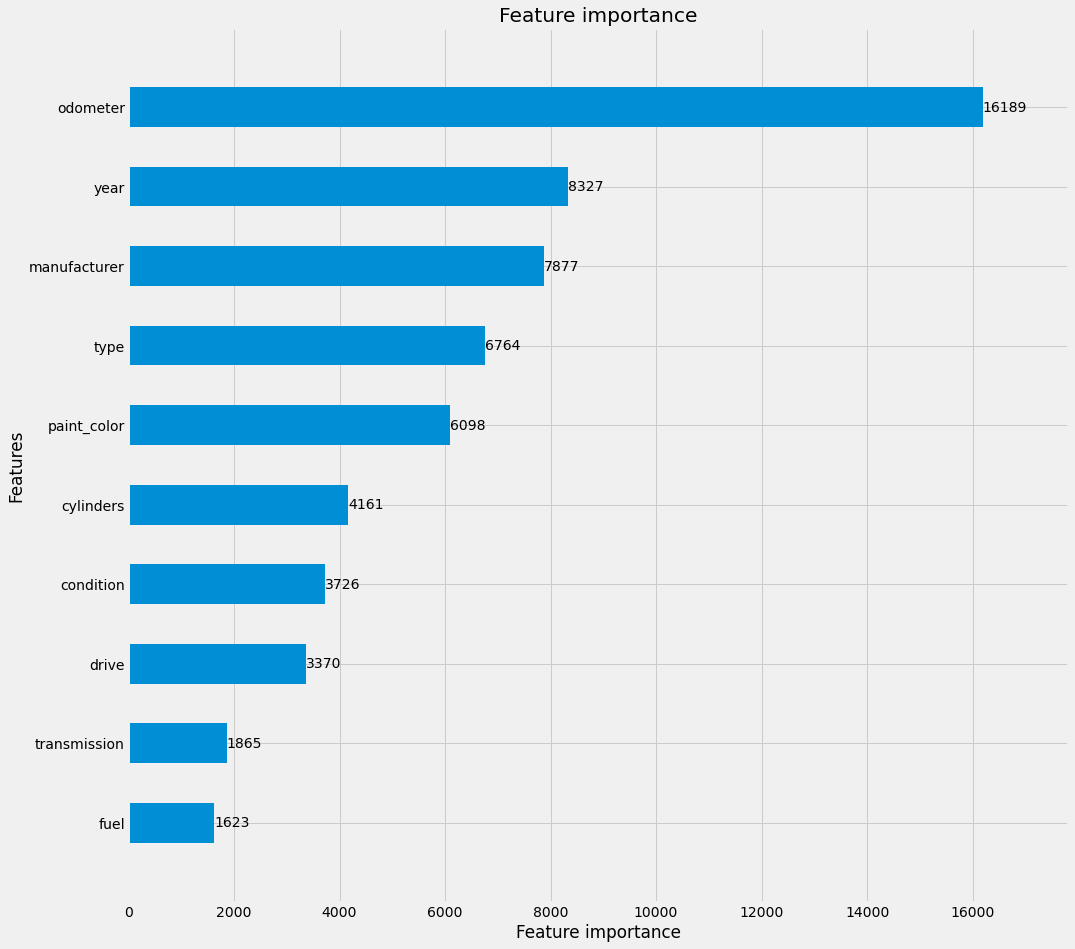

In [17]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgbm.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();plt.close()

#### As we can see the most important feature which decides the proce of a car is odometer i.e. how much miles that car has covered followed by year of purchase and manufacturer.

In [18]:
feature_score = pd.DataFrame(train0.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

#### XGB method for Feature extraction

In [19]:
#%% split training set to validation set 
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval   , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [20]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=10)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[0]	train-rmse:12269.2	valid-rmse:12333.2
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[10]	train-rmse:3110.3	valid-rmse:3318.04
[20]	train-rmse:2863.63	valid-rmse:3111.93
[30]	train-rmse:2739.79	valid-rmse:3016.46
[40]	train-rmse:2638.09	valid-rmse:2955.92
[50]	train-rmse:2549.4	valid-rmse:2907.63
[60]	train-rmse:2491.36	valid-rmse:2884.47
[70]	train-rmse:2424.54	valid-rmse:2855.95
[80]	train-rmse:2391.37	valid-rmse:2842
[90]	train-rmse:2349.84	valid-rmse:2825.17
[100]	train-rmse:2311.59	valid-rmse:2808.23
[110]	train-rmse:2269.45	valid-rmse:2796.11
[120]	train-rmse:2238.39	valid-rmse:2786.27
[130]	train-rmse:2198.51	valid-rmse:2774
[140]	train-rmse:2177.46	valid-rmse:2769.02
[150]	train-rmse:2157.6	valid-rmse:2767.25
[160]	train-rmse:2119.79	valid-rmse:2756.75
[170]	train-rmse:2088.87	valid-rmse:2750.47
[180]	train-rmse:2060.48	valid-rmse:2743.19
[190]	train-rmse:2034.39	valid-rmse:273

In [21]:
r2_score(Zval, modelx.predict(data_cv))

0.924685785786828

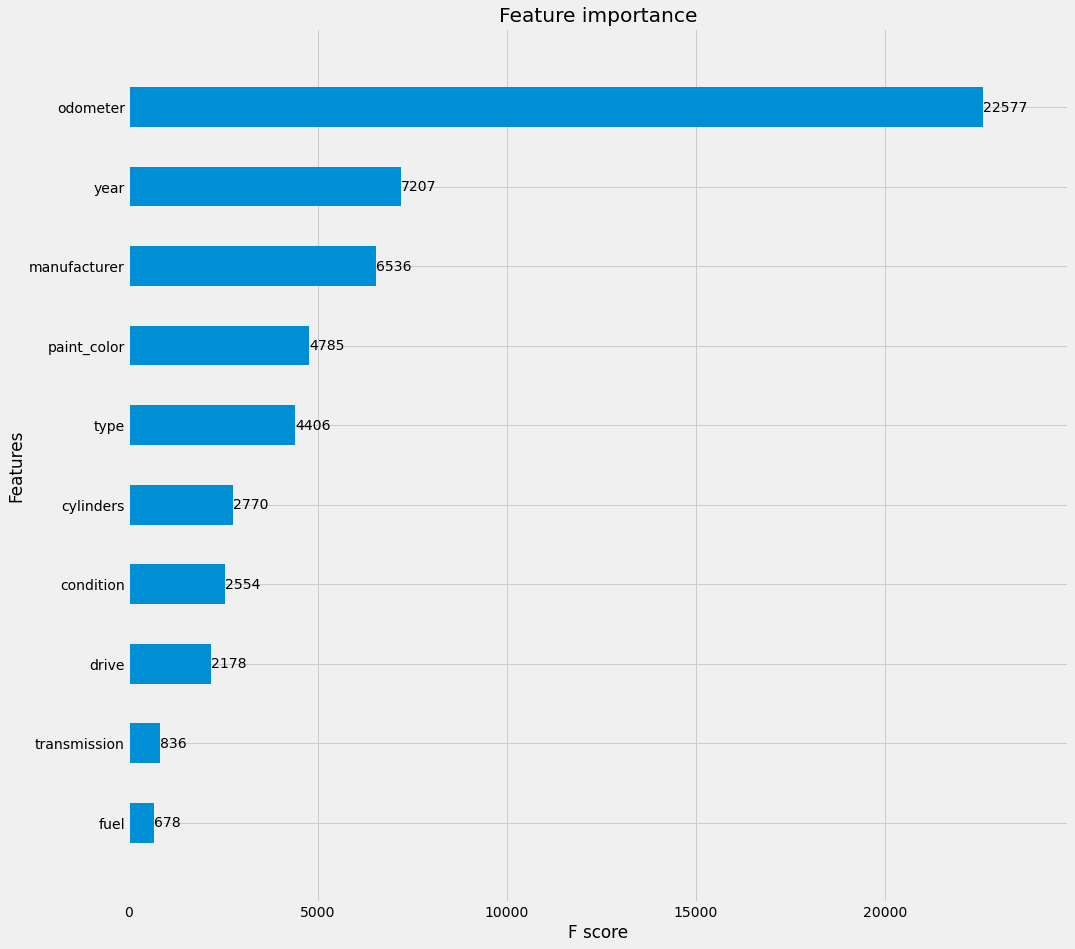

In [22]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

#### With an accuracy of whooping 93% XGB method also tell us the same story that odometer reading is the primary feature which determines the price of a pre owned car.

In [23]:
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))
feature_score

feature  score_lgb  score_xgb
0          year       8327       7207
1  manufacturer       7877       6536
2     condition       3726       2554
3     cylinders       4161       2770
4          fuel       1623        678
5      odometer      16189      22577
6  transmission       1865        836
7         drive       3370       2178
8          type       6764       4406
9   paint_color       6098       4785

#### Linear Regression for Feature Extraction

In [24]:
# Standardization for regression model
train = pd.DataFrame(
    MinMaxScaler().fit_transform(train0),
    columns=train0.columns,
    index=train0.index
)

In [25]:
# Linear Regression

linreg = LinearRegression()
linreg.fit(train, target)
coeff_linreg = pd.DataFrame(train.columns.delete(0))
coeff_linreg.columns = ['feature']
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

feature  score_linreg
3          fuel  21968.457053
0  manufacturer  20735.656557
6         drive   4557.936633
1     condition   1260.144163
2     cylinders    975.095833
8   paint_color    683.522492
7          type  -2482.586547
4      odometer  -9227.937478
5  transmission -12150.839362

In [26]:
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs()
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')
feature_score

score_lgb  score_xgb  score_linreg
feature                                         
manufacturer       7877       6536  20735.656557
condition          3726       2554   1260.144163
cylinders          4161       2770    975.095833
fuel               1623        678  21968.457053
odometer          16189      22577   9227.937478
transmission       1865        836  12150.839362
drive              3370       2178   4557.936633
type               6764       4406   2482.586547
paint_color        6098       4785    683.522492

## Comparison of the all feature importance diagrams

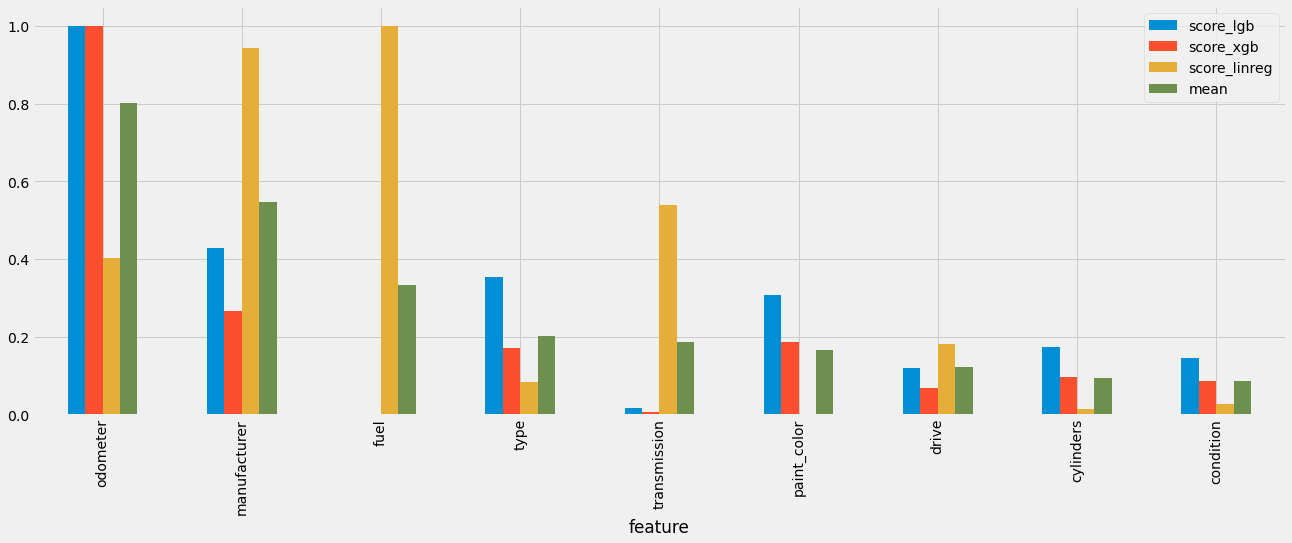

In [29]:
# MinMax scale all importances
feature_score = pd.DataFrame(
    MinMaxScaler().fit_transform(feature_score),
    columns=feature_score.columns,
    index=feature_score.index
)

# Create mean column
feature_score['mean'] = feature_score.mean(axis=1)

# Plot the feature importances
feature_score.sort_values('mean', ascending=False).plot(kind='bar', figsize=(20, 7))

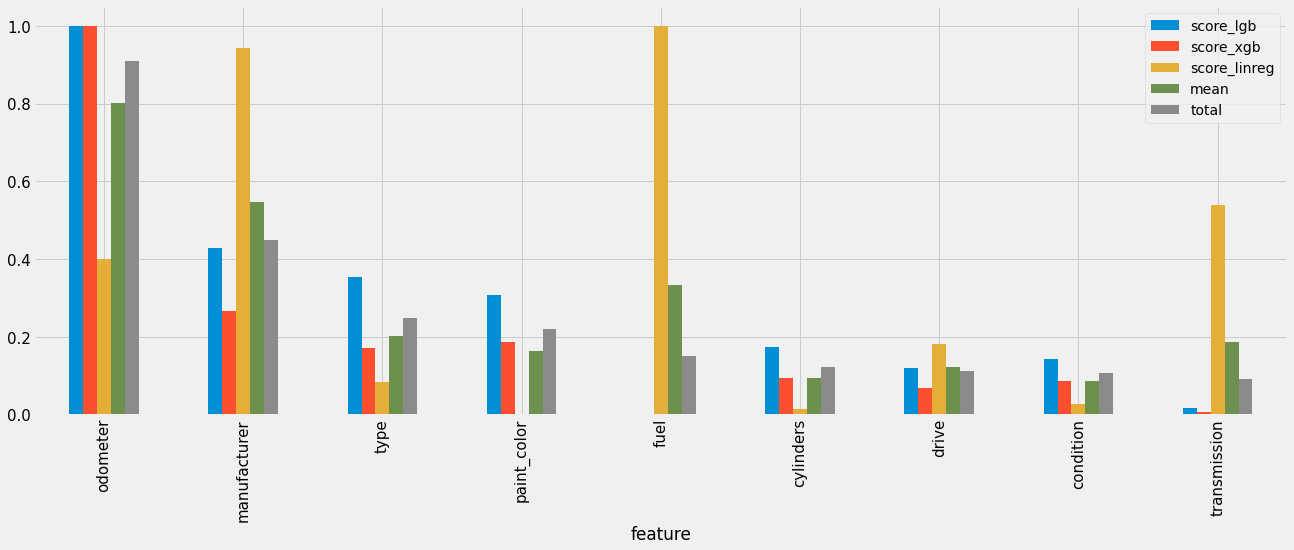

In [30]:
# Create total column with different weights
feature_score['total'] = 0.5*feature_score['score_lgb'] + 0.35*feature_score['score_xgb'] + 0.15*feature_score['score_linreg']

# Plot the feature importances
feature_score.sort_values('total', ascending=False).plot(kind='bar', figsize=(20, 7), fontsize=15)

## Conclusion

The features which should be highlighted when dealing with customer negotiation are as follows:
1. Odometer reading of the car
2. Manufacturer of the car.
3. Type of fuel on which the car runs.

Focus should be on those cars which have low odometer reading with reliable and trusted manufacturer. If we focus on these aspects the customer will be think of the car as close to as new one rather than a second hand purchase.

As for the ones who don't have satisfactory values for either of the above mentioned feautures should focus on making the car condition excellent along with highlighting the category of the car (for ex. sedan, SUV etc.). In such cases color of paint on the car can be a deciding factor too, as it is quite significantly evident that how paint can alter the price of cars too. 